In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import cv2
from IPython.display import Image
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from sklearn.utils import shuffle
from keras.layers import Dense, Conv2D,TimeDistributed,Dropout,Layer,Normalization
from keras.layers import MaxPooling2D, Flatten, BatchNormalization,Concatenate,GlobalAveragePooling2D
from keras.layers import SimpleRNN, LSTM
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
from sklearn.model_selection import KFold,StratifiedKFold, LeaveOneOut
from keras import Input, Model
from scipy import stats, ndimage, misc
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from sklearn.metrics import classification_report
import random
from keras import backend as K
%config InlineBackend.figure_format = 'retina'

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


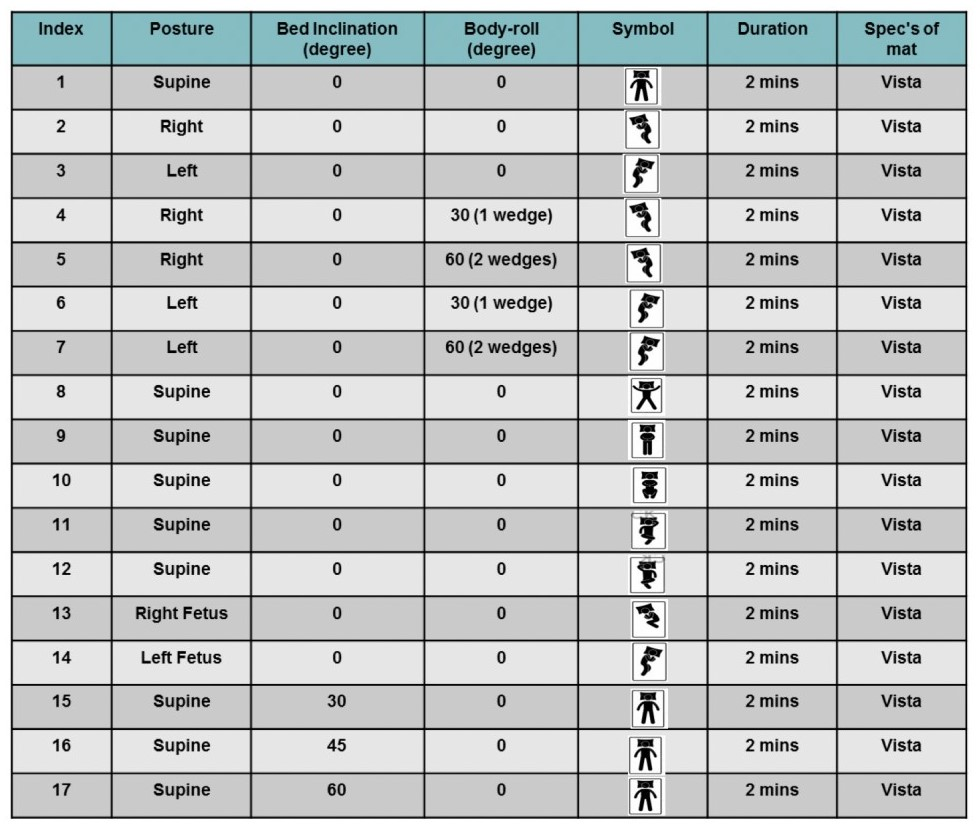

In [ ]:
Image("postures_index.jpg")

# Functions

In [4]:
def read_experiment_1_17(directory="experiment-i/"):
    li = []

    for root, subdirectories, files in os.walk(directory):
        for file in files:
            if file.endswith('.txt'):
                data = pd.read_csv(os.path.join(root, file),encoding='utf-8',sep='',delimiter='\t',
                               keep_default_na=False,header=None, skiprows=3)
                data.drop(data.columns[len(data.columns)-1], axis=1, inplace=True)
                data = data.iloc[:-3,:]
                data['posture'] = int(str(file)[:-4])
                data['subject'] = str(root[-2:])
                li.append(data)
            else:
                continue
        
    frames = pd.concat(li, axis=0, ignore_index=True)
    return frames

def read_experiment_1_3(directory="experiment-i/"):

    li = []
    for root, subdirectories, files in os.walk(directory):
        for file in files:
            if file.endswith('.txt'):
                if file == '1.txt' or file == '8.txt' or file == '9.txt' or file == '10.txt' or file == '11.txt' or file == '12.txt' or file == '15.txt' or file == '16.txt' or file == '17.txt':
                    data = pd.read_csv(os.path.join(root, file),encoding='utf-8',sep='',delimiter='\t',keep_default_na=False,header=None,skiprows=3)
                    data.drop(data.columns[len(data.columns)-1], axis=1, inplace=True)
                    data = data.iloc[:-3,:]
                    data['posture'] = str(1)
                    data['subject'] = str(root[-2:])
                    li.append(data)
                if file == '3.txt' or file == '6.txt' or file == '7.txt' or file == '14.txt':
                    data = pd.read_csv(os.path.join(root, file),encoding='utf-8',sep='',delimiter='\t',keep_default_na=False,header=None,skiprows=3)
                    data.drop(data.columns[len(data.columns)-1], axis=1, inplace=True)
                    data = data.iloc[:-3,:]
                    data['posture'] = str(2)
                    data['subject'] = str(root[-2:])
                    li.append(data)
                if file == '2.txt' or file == '4.txt' or file == '5.txt' or file == '13.txt':          
                    data = pd.read_csv(os.path.join(root, file),encoding='utf-8',sep='',delimiter='\t',keep_default_na=False,header=None,skiprows=3)
                    data.drop(data.columns[len(data.columns)-1], axis=1, inplace=True)
                    data = data.iloc[:-3,:]
                    data['posture'] = str(3)
                    data['subject'] = str(root[-2:])
                    li.append(data)
            else:
                continue
        
    frames = pd.concat(li, axis=0, ignore_index=True)
    return frames

def preprocess(dataframe, test_size):
    
    x = frames.iloc[:,:-2].values.reshape(len(frames),64,32,1)
    x = ndimage.median_filter(x, 3) 
    norm = lambda s: s/1000            #1000 is the maximum value of the pressure on the sensors
    x = np.array([norm(xx) for xx in x])

    y_pos = frames.iloc[:,-2].values
    y_pos = pd.get_dummies(frames['posture']).values

    y_sub = frames.iloc[:,-1].values
    y_sub = pd.get_dummies(frames['subject']).values
    
    X_train,X_test,y_train_pos,y_test_pos,y_train_sub,y_test_sub = train_test_split(x,
                                                                                    y_pos,
                                                                                    y_sub,
                                                                                    test_size = test_size,
                                                                                    shuffle=True)
    print('X train',X_train.shape)
    print('X test',X_test.shape)
    print('Y train position',y_train_pos.shape)
    print('Y train subject',y_train_sub.shape)
    print('Y test position',y_test_pos.shape)
    print('Y test subject',y_test_sub.shape)
    
    return X_train, X_test, y_train_pos, y_train_sub, y_test_pos, y_test_sub

def rot90_on_probability(image, probability= 0.5):
    if random.random() < probability:
        return tf.image.rot90(image,k=2)
    return image

def rot_on_probability(image, probability = 0.2):
    if random.random() < probability:
        return tf.keras.preprocessing.image.random_rotation(image,30, channel_axis=2)
    return image

def horiz_on_probability(image, probability = 0.2, shift = 0.1):
    if random.random() < probability:
        return tf.keras.preprocessing.image.random_shift(image,wrg=shift,hrg=0.,fill_mode='nearest', channel_axis=2)
    return image

def vertic_on_probability(image, probability = 0.2, shift = 0.1):
    if random.random() < probability:
        return tf.keras.preprocessing.image.random_shift(image,wrg=0.,hrg=shift,fill_mode='nearest', channel_axis=2)
    return image

def data_augmentation(X_train, plot=True):
    
    from tensorflow.python.ops.numpy_ops import np_config #non so perchè ma servono quest due righe
    np_config.enable_numpy_behavior() #non so perchè ma servono quest due righe
    X_train_aug = np.empty([len(X_train),64,32,1], dtype='float32')
    
    for i in tqdm(range(X_train_aug.shape[0])):
        image = X_train[i]
        image = tf.convert_to_tensor(image, np.float32)
        image = rot90_on_probability(image)
        image = rot_on_probability(image)
        image = horiz_on_probability(image)
        image = vertic_on_probability(image)
        X_train_aug[i] = image
        
    if X_train_aug.shape == X_train.shape:
        print('Data Augmentation Done!')
        
        if plot:
            plt.figure(figsize=(20,20)) 
            for i in range(10):
                seed = np.random.randint(0,1000)
                plt.subplot(5,5,i+1) 
                plt.imshow(X_train_aug[seed])
                plt.axis('off')
            plt.show()
    else:
        print('Error!')        
        
    return X_train_aug


def cnn_model(n_conv=2, n_channels=32, n_dense=3, n_neurons=512, n_pos=3, summary=True):
    
    #input block
    input = Input(shape=(64,32,1), name='Input')
    
    #encoder block
    for i in range(n_conv):
        x = Conv2D(n_channels*(i+1), kernel_size=3, activation='leaky_relu', name='Conv-{}a'.format(i+1))(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(name='MaxPool-{}'.format(i))(x)
        n2 = n_channels*(i+1) 
        
    for i in range(2):
        x = Conv2D(n2*(i+1), kernel_size=3, activation='leaky_relu', name='Conv-{}b'.format(i+1))(x)

    #flatten block
    x = Flatten(name='Flatten')(x)
    
    #output block
    for i in range(n_dense):
        x = Dense(n_neurons/(2**i), activation='leaky_relu', name='Dense-{}a'.format(i+1))(x)
        
    x = Dropout(0.2, name='Dropout-1')(x)    
    x1 = Dense(13, activation='softmax', name='Subject')(x)
    x2 = Dense(n_pos, activation='softmax', name='Position')(x)
    
    model = Model(inputs=input, outputs=[x1,x2], name='HDA')
    if summary:
        model.summary()
    
    pos_layer = model.layers[-1].name
    sub_layer = model.layers[-2].name
    
    return model, pos_layer, sub_layer

def train_model(model, X_train, y_train_sub, y_train_pos,lambda_=0.5, verbose=1, validation_split=0.2, batch_size=100,
                n_epochs=10, plot=True, name_model='3_positions.h5'):
    
    model.compile(loss=['categorical_crossentropy', 'categorical_crossentropy'],
              loss_weights = [lambda_,1-lambda_],
              optimizer='adam',
              metrics=['accuracy'])
    
    monitor_ = "val_{}_accuracy".format(sub_layer) #monitoring validation accuracy of the subjects

    my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10,monitor=monitor_),
    tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor_,factor=0.5,patience=5, min_lr=0.0001)
    ]
    
    try: history = model.fit(X_train,
                    [y_train_sub,y_train_pos],
                    shuffle=True,
                    epochs=n_epochs, 
                    batch_size=batch_size,
                    validation_split = validation_split, #validate on the augmented data
                    callbacks=my_callbacks,
                    verbose=verbose)

    except KeyboardInterrupt: #stopping training saves the model
        model.save(name_model)
        print('\n ---------------------')
        print('Output saved to: {}'.format(name_model))
        print('---------------------')
        
    model.save(name_model)
    
    if plot:
        plt.plot(history.history['{}_accuracy'.format(sub_layer)])
        plt.plot(history.history['{}_accuracy'.format(pos_layer)])
        plt.plot(history.history['val_{}_accuracy'.format(sub_layer)])
        plt.plot(history.history['val_{}_accuracy'.format(pos_layer)])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend([ 'Train Subject Accuracy','Train Position Accuracy','Val Position Accuracy','Val Subject Accuracy'],
           loc='lower right')
        plt.show()
        
    return model

def test_model(X_test, y_test_sub, y_test_pos, plot=True, classification_rep=True):
    
    sub_pred, pos_pred = model.predict(X_test)
    true_sub, true_pos = y_test_sub.argmax(-1), y_test_pos.argmax(-1)
    sub_pred = sub_pred.argmax(-1)
    pos_pred = pos_pred.argmax(-1)
    
    acc_pos = round(np.sum(true_pos == pos_pred)*100/pos_pred.size,2)
    acc_sub = round(np.sum(true_sub == sub_pred)*100/sub_pred.size,2)


    print('Position Test accuracy:',acc_pos,'%')
    print('Subject Test accuracy:',acc_sub,'%')
    print('---------------------')
    print('---------------------')
    
    if classification_rep:
        print('Posture Classification report')
        print(classification_report(true_pos, pos_pred))

        print('Subject Classification report')
        print(classification_report(true_sub, sub_pred))
    
    matrix_sub = confusion_matrix(true_sub, sub_pred)
    matrix_pos = confusion_matrix(true_pos, pos_pred)
    
    if plot:
        df = pd.DataFrame(matrix_pos)
        n = matrix_pos.shape[0]
        if n==3:
            df = df.rename(columns={0:'Supine',1:'Right',2:'Left'})
        else: 
            df.columns = [1,8,9,10,11,12,15,16,17,2,4,5,13,3,6,7,14]
            df = df.rename(columns={1:'Supine',8:'Supine Star',9:'Supine Hand Crossed',10:'Supine Knees Up',
                   11:'Supine Right Knee Up',12:'Supine Left Knee Up',15:'Supine 30° Bed Inclination',16:'Supine 45° Bed Inclination',
                   17:'Supine 60° Bed Inclination',2:'Right',4:'Right 30° Body Roll',5:'Right 60° Body Roll',13:'Right Fetus',
                  3:'Left',6:'Left 30° Body Roll',7:'Left 60 Body Roll',14:'Left Fetus'})

        #normalization
        row_sums = matrix_sub.sum(axis=1)
        matrix_sub_norm = matrix_sub / row_sums[:, np.newaxis]
        row_sums = matrix_pos.sum(axis=1)
        matrix_pos_norm = matrix_pos / row_sums[:, np.newaxis]

        label_sub = [str('Subject: ')+str(i) for i in range(1,14)]

        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,8)) 

        sns.heatmap(matrix_pos_norm, annot=matrix_pos,xticklabels=list(df.columns), yticklabels=list(df.columns),
            fmt="g",cmap='Blues',ax=ax1,vmin=0, vmax=1,square=True)
        
        if n==3:
            ax1.hlines([0],*ax1.get_xlim(), color='black',lw=2)
            ax1.vlines([3],*ax1.get_xlim(), color='black',lw=2)
            ax1.hlines([3],*ax1.get_xlim(), color='black',lw=2)
            ax1.vlines([0],*ax1.get_xlim(), color='black',lw=2)
        else:
            ax1.hlines([9, 13],*ax1.get_xlim(), color='black',lw=2)
            ax1.vlines([9, 13],*ax1.get_xlim(), color='black',lw=2)
            ax1.hlines([0],*ax1.get_xlim(), color='black',lw=2)
            ax1.vlines([17],*ax1.get_xlim(), color='black',lw=2)
            ax1.hlines([17],*ax1.get_xlim(), color='black',lw=2)
            ax1.vlines([0],*ax1.get_xlim(), color='black',lw=2)
            

        sns.heatmap(matrix_sub_norm, annot=matrix_sub,xticklabels=label_sub, yticklabels=label_sub,
            fmt="g",cmap='Blues',ax=ax2,vmin=0, vmax=1,square=True)
        ax2.hlines([0],*plt.xlim(), color='black',lw=2)
        ax2.vlines([13],*plt.xlim(), color='black',lw=2)
        ax2.hlines([13],*plt.xlim(), color='black',lw=2)
        ax2.vlines([0],*plt.xlim(), color='black',lw=2)

        plt.show()
        
    return acc_pos, acc_sub, matrix_pos, matrix_sub

# Subject + 3 Positions

In [3]:
#frames = read_experiment_1_3()
#frames.to_csv('Experiment1_3pos.csv',header=True, index=False)
frames = pd.read_csv('Experiment1_3pos.csv',  header=0)
frames.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,posture,subject
0,0,0,0,0,1,0,5,4,5,2,6,4,8,15,15,8,2,1,1,1,0,1,0,0,0,10,1,14,3,2,0,0,1,2,0,0,2,1,4,1,6,1,12,14,63,124,159,65,6,0,3,0,0,0,0,0,0,0,0,2,...,3,9,2,4,50,191,90,23,261,116,10,4,2,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,2,3,8,22,5,11,22,43,16,6,41,34,9,10,4,4,1,2,1,0,0,0,0,0,0,0,0,0,1,1
1,0,1,0,0,1,0,6,4,5,1,5,4,8,14,15,7,3,1,1,0,0,1,0,0,0,11,3,14,2,3,0,0,1,2,0,0,2,1,3,1,6,1,13,14,65,132,163,68,7,1,1,0,0,0,0,0,0,2,0,1,...,3,9,2,4,51,191,93,25,266,118,8,4,2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,4,9,23,4,11,21,43,15,6,40,33,9,10,4,5,1,2,1,0,0,0,0,0,0,0,0,0,1,1
2,0,0,0,0,1,0,5,4,4,1,5,5,6,14,15,8,3,2,1,0,1,1,0,0,0,11,3,13,4,3,0,0,1,2,1,0,1,1,3,1,6,1,13,15,56,124,157,67,7,0,2,0,0,0,0,0,0,2,0,1,...,3,9,3,4,52,193,92,25,270,117,10,4,2,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,3,9,21,5,10,21,44,14,7,39,30,9,10,3,4,1,2,3,0,0,0,0,0,0,0,0,0,1,1
3,0,0,0,0,1,0,5,4,4,1,5,4,8,16,15,9,3,1,1,1,0,0,0,0,0,11,1,14,4,3,0,0,2,2,1,1,3,1,3,1,6,1,13,15,64,131,160,67,7,0,3,0,0,0,0,0,0,3,0,1,...,3,9,2,4,53,193,95,26,271,118,9,4,2,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,2,3,9,23,5,10,21,45,15,7,40,32,9,10,3,5,1,2,1,0,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,6,4,4,1,6,5,10,15,15,8,2,1,1,0,1,1,0,1,0,11,2,13,4,3,0,0,2,3,1,1,2,1,3,1,7,1,12,17,65,133,161,70,6,1,3,0,0,0,0,0,0,1,0,1,...,3,9,2,4,51,196,93,25,273,118,11,3,2,3,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,2,2,3,7,23,5,10,22,44,15,6,39,29,10,10,3,5,1,2,2,0,0,0,0,0,0,0,0,0,1,1


In [5]:
X_train, X_test, y_train_pos, y_train_sub, y_test_pos, y_test_sub = preprocess(frames, test_size=0.2)

X train (14958, 64, 32, 1)
X test (3740, 64, 32, 1)
Y train position (14958, 3)
Y train subject (14958, 13)
Y test position (3740, 3)
Y test subject (3740, 13)


100%|██████████████████████████████████████████████████████████████████████████| 14958/14958 [00:11<00:00, 1350.33it/s]


Data Augmentation Done!


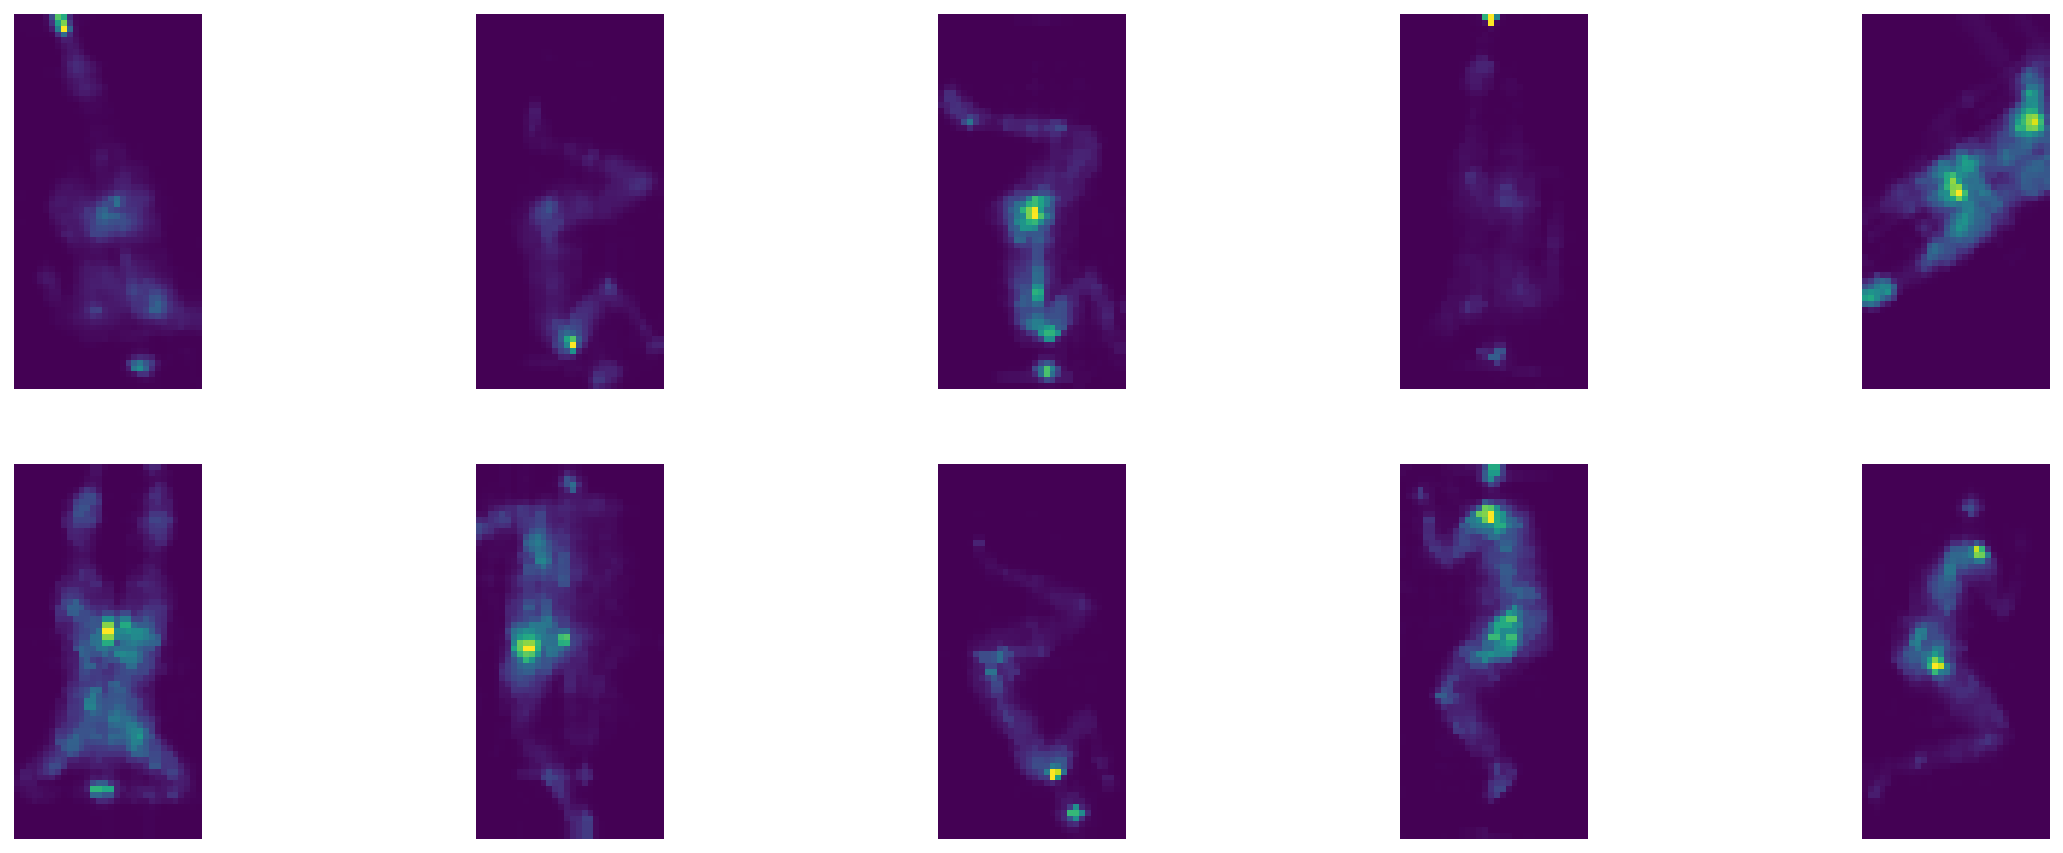

In [8]:
X_train_aug = data_augmentation(X_train, plot=True)

In [15]:
model, pos_layer, sub_layer = build_model(n_dense=1,
                                    n_neurons=64, n_pos=17, summary=True)

Model: "HDA"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 64, 32)]     0           []                               
                                                                                                  
 simple_rnn_2 (SimpleRNN)       (None, 64, 16)       784         ['Input[0][0]']                  
                                                                                                  
 simple_rnn_3 (SimpleRNN)       (None, 16)           528         ['simple_rnn_2[0][0]']           
                                                                                                  
 Flatten (Flatten)              (None, 16)           0           ['simple_rnn_3[0][0]']           
                                                                                                

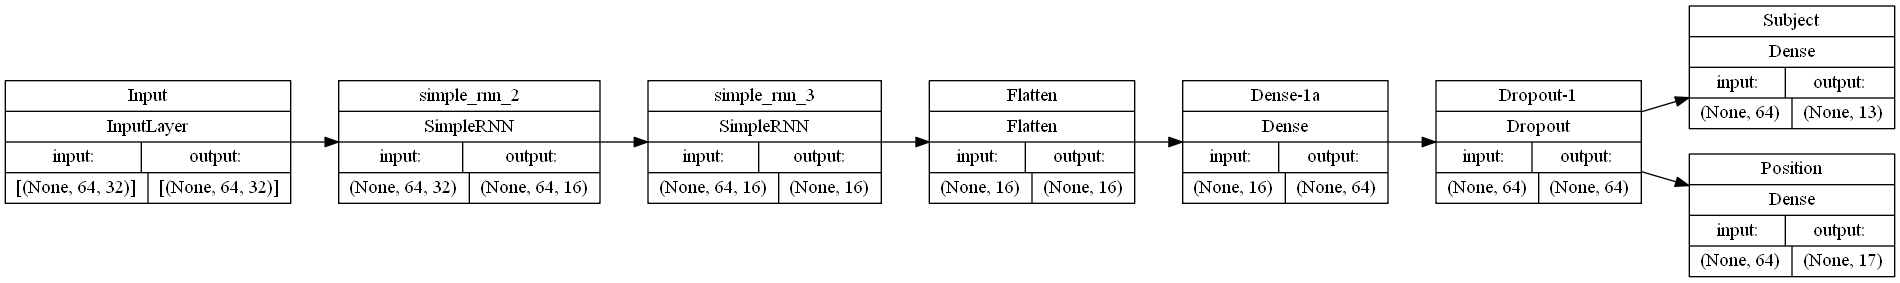

In [16]:
plot_model(model, show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='LR', expand_nested=True ) #per plot verticale cambiare 'LR' --> 'TB'

Epoch 1/15
240/240 [==============================] - 30s 120ms/step - loss: 0.7904 - Subject_loss: 1.0077 - Position_loss: 0.2834 - Subject_accuracy: 0.6729 - Position_accuracy: 0.8926 - val_loss: 0.4471 - val_Subject_loss: 0.5919 - val_Position_loss: 0.1093 - val_Subject_accuracy: 0.8045 - val_Position_accuracy: 0.9611 - lr: 0.0010
Epoch 2/15
240/240 [==============================] - 28s 116ms/step - loss: 0.2812 - Subject_loss: 0.3610 - Position_loss: 0.0950 - Subject_accuracy: 0.8865 - Position_accuracy: 0.9667 - val_loss: 0.2905 - val_Subject_loss: 0.3834 - val_Position_loss: 0.0738 - val_Subject_accuracy: 0.8752 - val_Position_accuracy: 0.9763 - lr: 0.0010
Epoch 3/15
240/240 [==============================] - 27s 114ms/step - loss: 0.1917 - Subject_loss: 0.2461 - Position_loss: 0.0650 - Subject_accuracy: 0.9192 - Position_accuracy: 0.9788 - val_loss: 0.2100 - val_Subject_loss: 0.2784 - val_Position_loss: 0.0506 - val_Subject_accuracy: 0.9161 - val_Position_accuracy: 0.9851 - lr:

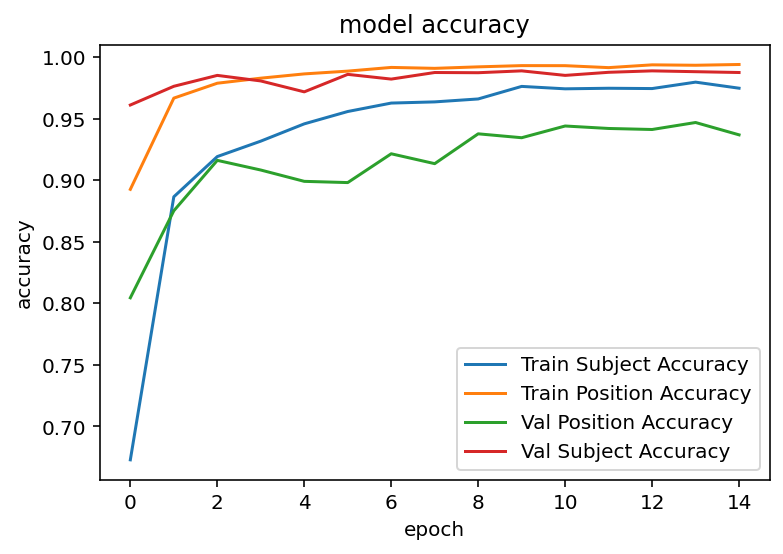

In [14]:
model = train_model(
                    model, X_train_aug, y_train_sub, y_train_pos,
                    n_epochs=15, lambda_=0.7, verbose=1, validation_split=0.2, batch_size=100,
                    plot=True, name_model='3_positions.h5')

Position Test accuracy: 99.76 %
Subject Test accuracy: 99.26 %
---------------------
---------------------
Posture Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3969
           1       1.00      0.99      0.99      1762
           2       0.99      1.00      1.00      1749

    accuracy                           1.00      7480
   macro avg       1.00      1.00      1.00      7480
weighted avg       1.00      1.00      1.00      7480

Subject Classification report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       474
           1       1.00      0.98      0.99       463
           2       0.99      0.99      0.99       485
           3       1.00      1.00      1.00       461
           4       0.99      1.00      1.00       771
           5       1.00      0.97      0.98       498
           6       0.98      1.00      0.99       925
           7       

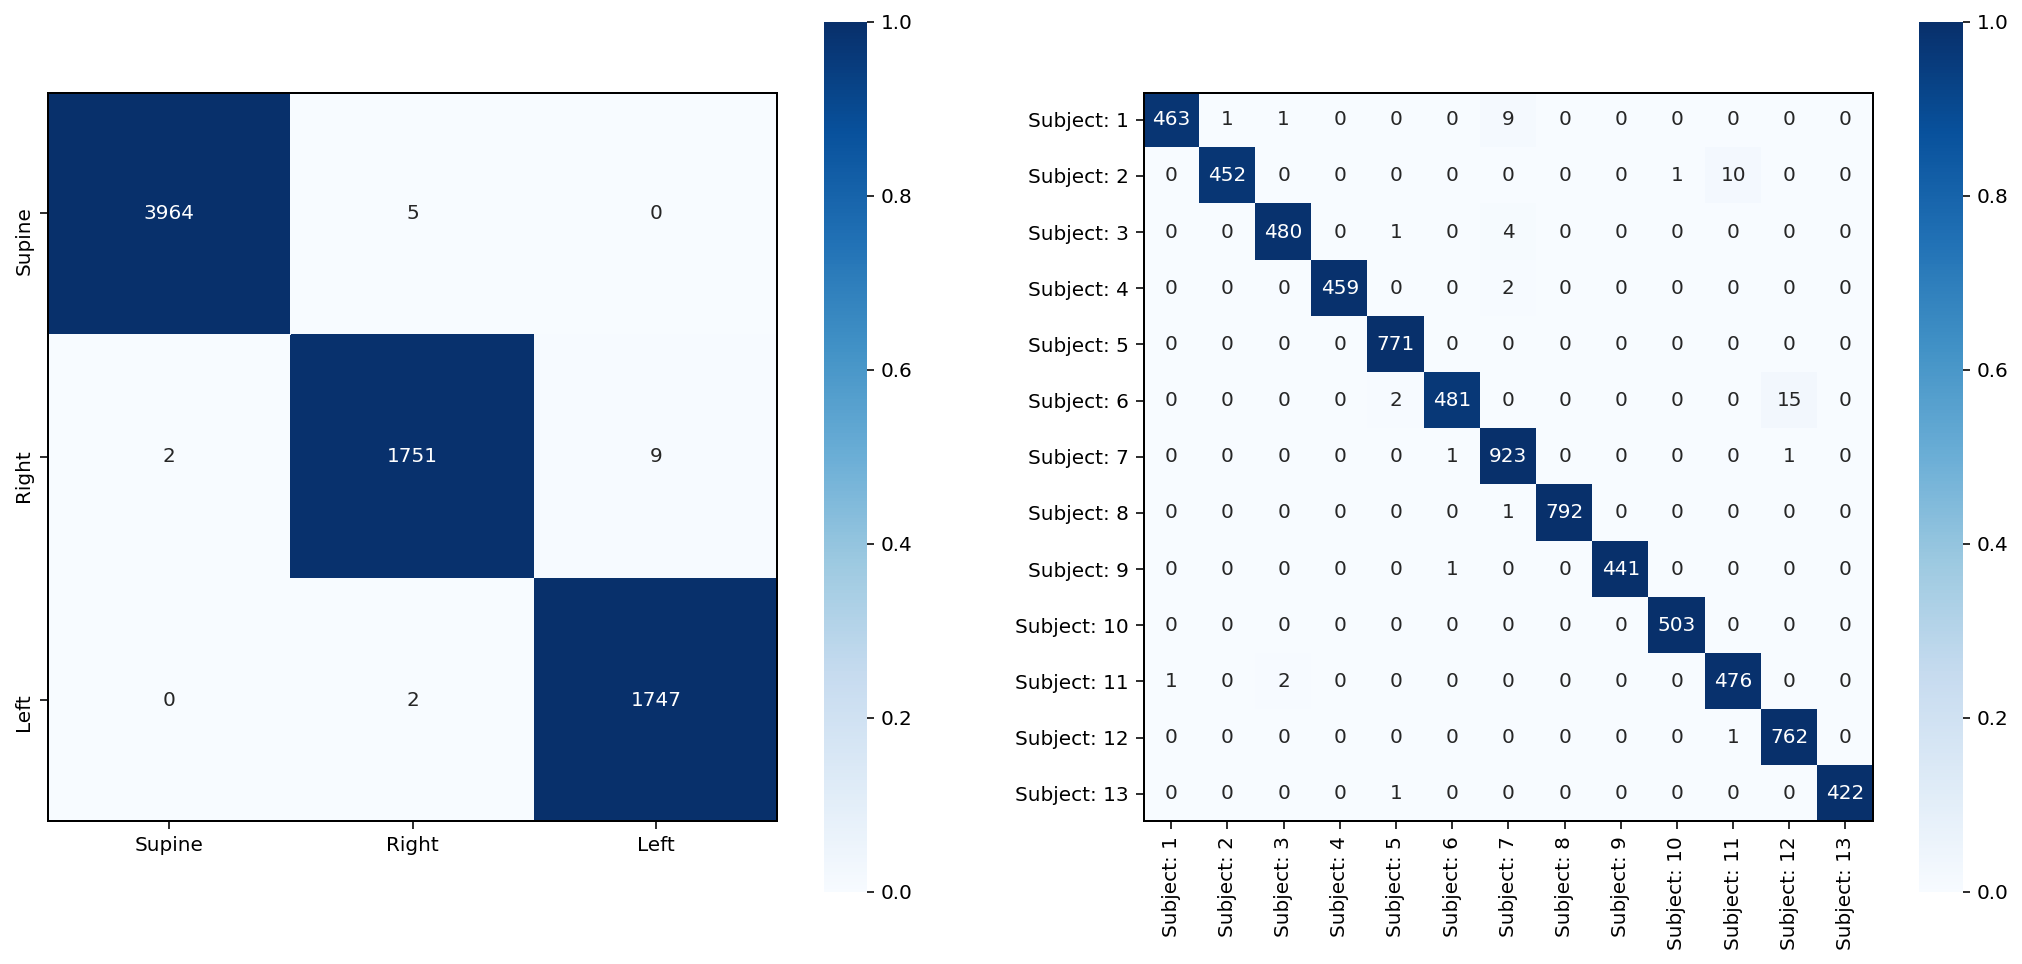

In [15]:
acc_pos, acc_pos, matrix_pos, matrix_sub = test_model(
                                                      X_test,y_test_sub, y_test_pos,
                                                      plot=True, classification_rep=True)

#### K-Fold Validation (Subject + 3 Positions)

In [22]:
x = frames.iloc[:,:-2].values.reshape(len(frames),32,64,1)
x = np.concatenate((x[:,:,:32],x[:,:,32:])) 
x = ndimage.median_filter(x, 2) #applying median filter of size 2
x_aug = data_augmentation(x, plot=False)

y_pos = frames.iloc[:,-2].values
y_pos = pd.get_dummies(frames['posture']).values

y_sub = frames.iloc[:,-1].values
y_sub = pd.get_dummies(frames['subject']).values

y_pos = np.concatenate((y_pos,y_pos)) #double the dataset
y_sub = np.concatenate((y_sub,y_sub))

100%|███████████████████████████████████████████████████████████████████████████| 37396/37396 [03:45<00:00, 165.82it/s]

Data Augmentation Done!


In [23]:
##### MAKE SURE ALL THE CODE ABOVE IS ALREADY RUNNED
kfold_acc_pos = []
kfold_acc_sub = []
fold=5 #number of folds
k=1

matrix_pos_ = np.zeros((3,3))
matrix_sub_ = np.zeros((13,13))

print('-----------------')
print('KFold Initialization.')
print('-----------------')

cv = KFold(n_splits=fold, shuffle=True, random_state=123)
for train, test in cv.split(x):

    X_train, X_test = tf.gather(x_aug, indices=train), tf.gather(x, indices=test) #ATTENZIONE 
    y_train_pos, y_test_pos = y_pos[train], y_pos[test]
    y_train_sub, y_test_sub = y_sub[train], y_sub[test]
    
    if k==1: 
        summary=True
    else: summary=False
        
    model, pos_layer, sub_layer = build_model(n_neurons=80, n_pos=3, summary=summary)

    model = train_model(model, X_train, y_train_sub, y_train_pos, 
                        plot=False, n_epochs=3, verbose=0, lambda_=0.7)

    acc_pos, acc_sub, matrix_pos, matrix_sub = test_model(X_test,y_test_sub, y_test_pos, 
                                                          plot=False, classification_rep=False)

    matrix_sub_ += matrix_sub
    matrix_pos_ += matrix_pos

    kfold_acc_pos.append(acc_pos)
    kfold_acc_sub.append(acc_sub)
    
    print('-----------------')
    print('{}-Kfold finished!'.format(k))
    print('-----------------')
    
    tf.keras.backend.clear_session()
    k+=1

print('-----------------')
print('-----------------')
print('Average KFold Position Accuracy:',round(np.mean(kfold_acc_pos),2),'%')
print('Average Kfold Subject Accuracy:',round(np.mean(kfold_acc_sub),2),'%')


-----------------
KFold Initialization.
-----------------
Model: "HDA"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 Normalization (Normalization)  (None, 32, 32, 1)    3           ['Input[0][0]']                  
                                                                                                  
 Conv-0a (Conv2D)               (None, 30, 30, 8)    80          ['Normalization[0][0]']          
                                                                                                  
 Conv-0b (Conv2D)               (None, 28, 28, 16)   1168        ['Conv-0a[0][0]']                
                                      

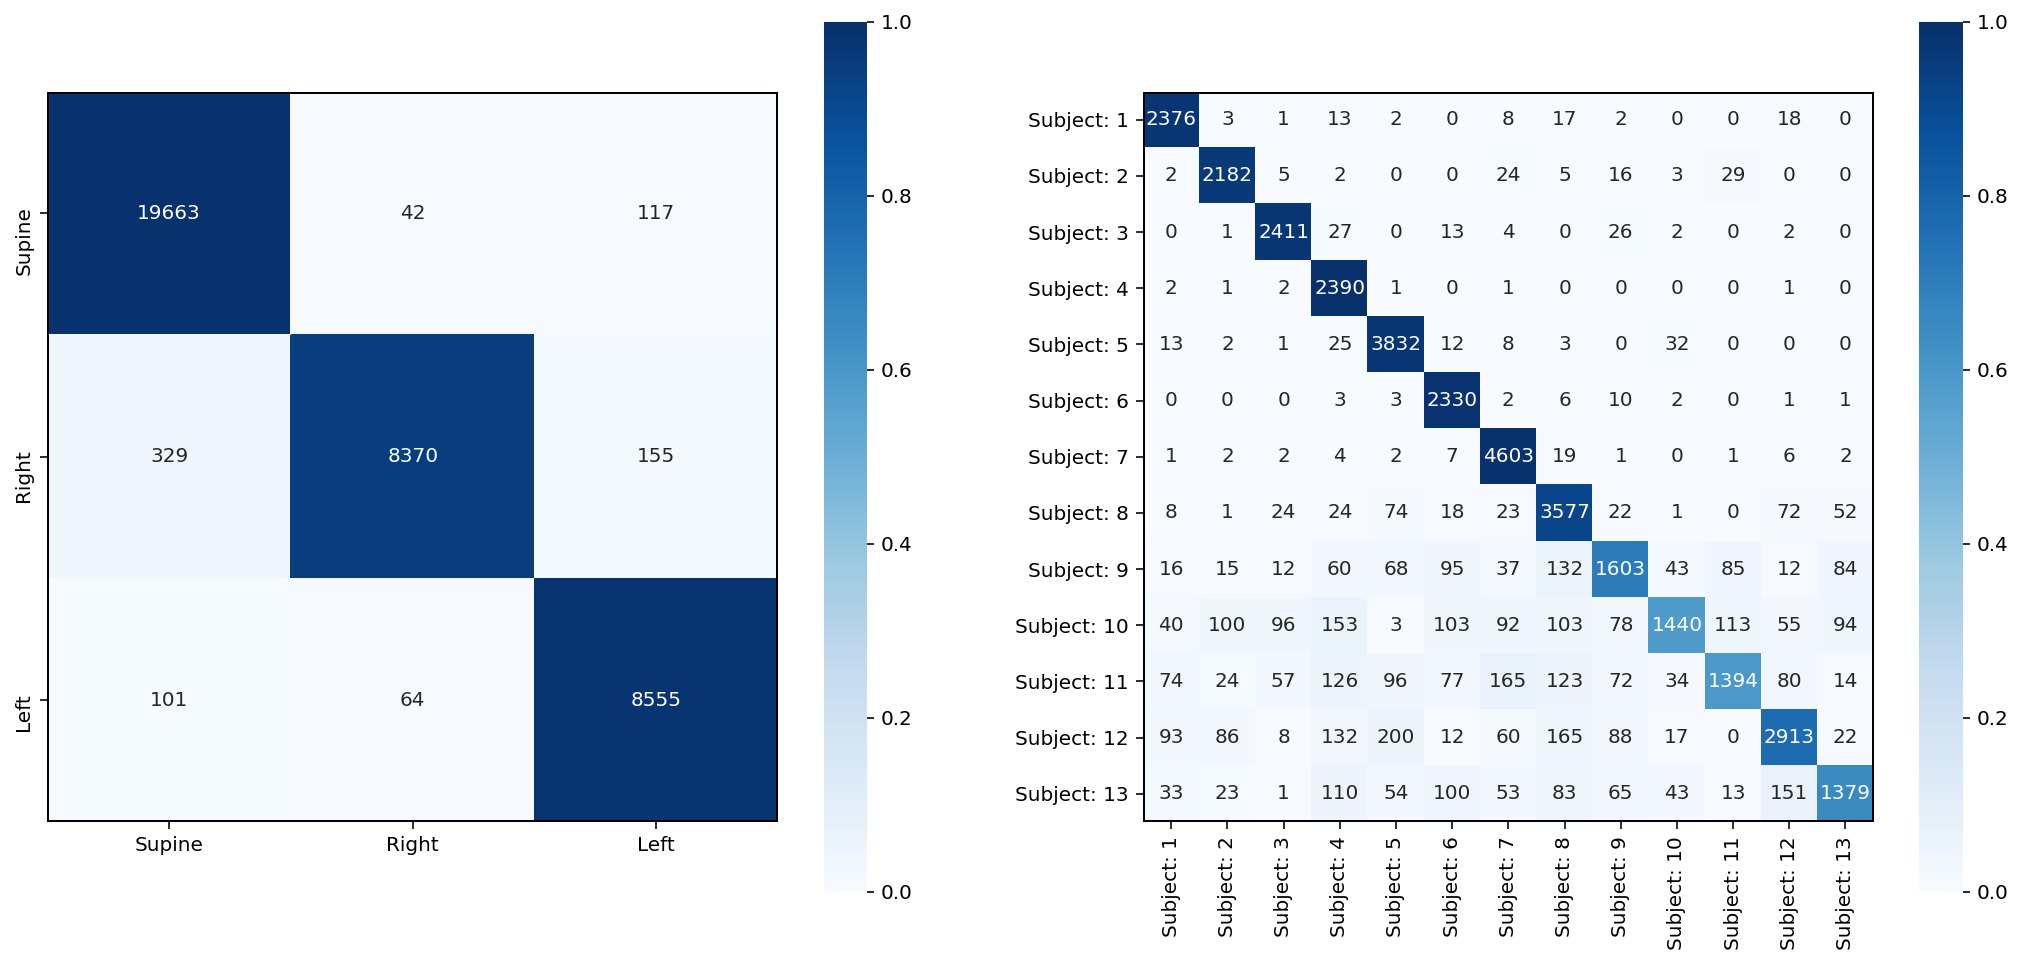

In [24]:
df = pd.DataFrame(matrix_pos_)
df = df.rename(columns={0:'Supine',1:'Right',2:'Left'})

#normalization
row_sums = matrix_sub_.sum(axis=1)
matrix_sub_norm = matrix_sub_ / row_sums[:, np.newaxis]
row_sums = matrix_pos_.sum(axis=1)
matrix_pos_norm = matrix_pos_ / row_sums[:, np.newaxis]

label_sub = [str('Subject: ')+str(i) for i in range(1,14)]

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,8)) 

sns.heatmap(matrix_pos_norm, annot=matrix_pos_,xticklabels=list(df.columns), yticklabels=list(df.columns),
            fmt="g",cmap='Blues',ax=ax1,vmin=0, vmax=1,square=True)
ax1.hlines([0],*ax1.get_xlim(), color='black',lw=2)
ax1.vlines([3],*ax1.get_xlim(), color='black',lw=2)
ax1.hlines([3],*ax1.get_xlim(), color='black',lw=2)
ax1.vlines([0],*ax1.get_xlim(), color='black',lw=2)

sns.heatmap(matrix_sub_norm, annot=matrix_sub_,xticklabels=label_sub, yticklabels=label_sub,
            fmt="g",cmap='Blues',ax=ax2,vmin=0, vmax=1,square=True)
ax2.hlines([0],*plt.xlim(), color='black',lw=2)
ax2.vlines([13],*plt.xlim(), color='black',lw=2)
ax2.hlines([13],*plt.xlim(), color='black',lw=2)
ax2.vlines([0],*plt.xlim(), color='black',lw=2)

plt.show()

# Subject + 17 Positions

In [6]:
#frames = read_experiment_1_17()
#frames.to_csv('Experiment1_17pos.csv',header=True, index=False)
frames = pd.read_csv('Experiment1_17pos.csv',  header=0)
frames = frames.drop(range(7939, 7951))
frames = frames.drop([6767, 10147])
frames.head(5)

,0,1,2,3,4,5,6,7,8,9,...,2040,2041,2042,2043,2044,2045,2046,2047,posture,subject
0,0,0,0,0,1,0,5,4,5,2,...,0,0,0,0,0,0,0,0,1,1
1,0,1,0,0,1,0,6,4,5,1,...,0,0,0,0,0,0,0,0,1,1
2,0,0,0,0,1,0,5,4,4,1,...,0,0,0,0,0,0,0,0,1,1
3,0,0,0,0,1,0,5,4,4,1,...,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,6,4,4,1,...,0,0,0,0,0,0,0,0,1,1


In [54]:
def rnn_model(n_dense=2, n_neurons=256, n_pos=17, summary=True):
    
    #input block
    input = Input(shape=(64,32), name='Input')
    
    x = SimpleRNN(128, return_sequences=True, activation='relu')(input)
    x = SimpleRNN(128, return_sequences=True, activation='relu')(x)
    x = SimpleRNN(64, return_sequences=True, activation='relu')(x)
    x = SimpleRNN(64, return_sequences=False, activation='relu')(x)

    #flatten block
    x = Flatten(name='Flatten')(x)
    
    #output block
    for i in range(n_dense):
        x = Dense(n_neurons/(2**i), activation='leaky_relu', name='Dense-{}a'.format(i+1))(x)
        
    x = Dropout(0.2, name='Dropout-1')(x)    
    x1 = Dense(13, activation='softmax', name='Subject')(x)
    x2 = Dense(n_pos, activation='softmax', name='Position')(x)
    
    model = Model(inputs=input, outputs=[x1,x2], name='HDA')
    if summary:
        model.summary()
    
    pos_layer = model.layers[-1].name
    sub_layer = model.layers[-2].name
    
    return model, pos_layer, sub_layer

In [91]:
def cnn_rnn_model(n_conv=2, n_channels=32, n_dense=3, n_neurons=512, n_pos=3, summary=True):
    
    #input block
    input = Input(shape=(64,32,1), name='Input')
    x = tf.keras.layers.Layer()(input)
    #encoder block
    for i in range(n_conv):
        x = Conv2D(n_channels*(i+1), kernel_size=3, activation='leaky_relu', name='Conv-{}a'.format(i+1))(x)
        x = BatchNormalization()(x)
        x = MaxPooling2D(name='MaxPool-{}'.format(i))(x)
        n2 = n_channels*(i+1) 
        
    for i in range(2):
        x = Conv2D(n2*(i+1), kernel_size=3, activation='leaky_relu', name='Conv-{}b'.format(i+1))(x)
        
    #flatten block
    x = tf.keras.layers.Reshape((x.shape[1], x.shape[3]*x.shape[2]))(x)
    x = SimpleRNN(128, return_sequences=True, activation='relu')(x)
    x = SimpleRNN(64, return_sequences=True, activation='relu')(x)
    x = SimpleRNN(64, return_sequences=False, activation='relu')(x)
    x = Flatten(name='Flatten')(x)
    
    #output block
    for i in range(n_dense):
        x = Dense(n_neurons/(2**i), activation='leaky_relu', name='Dense-{}a'.format(i+1))(x)
        
    x = Dropout(0.2, name='Dropout-1')(x)    
    x1 = Dense(13, activation='softmax', name='Subject')(x)
    x2 = Dense(n_pos, activation='softmax', name='Position')(x)
    
    model = Model(inputs=input, outputs=[x1,x2], name='HDA')
    if summary:
        model.summary()
    
    pos_layer = model.layers[-1].name
    sub_layer = model.layers[-2].name
    
    return model, pos_layer, sub_layer


  0%|▎                                                                             | 57/14947 [00:00<00:26, 563.16it/s]

X train (14947, 64, 32, 1)
X test (3737, 64, 32, 1)
Y train position (14947, 17)
Y train subject (14947, 13)
Y test position (3737, 17)
Y test subject (3737, 13)


100%|██████████████████████████████████████████████████████████████████████████| 14947/14947 [00:12<00:00, 1214.43it/s]


Data Augmentation Done!


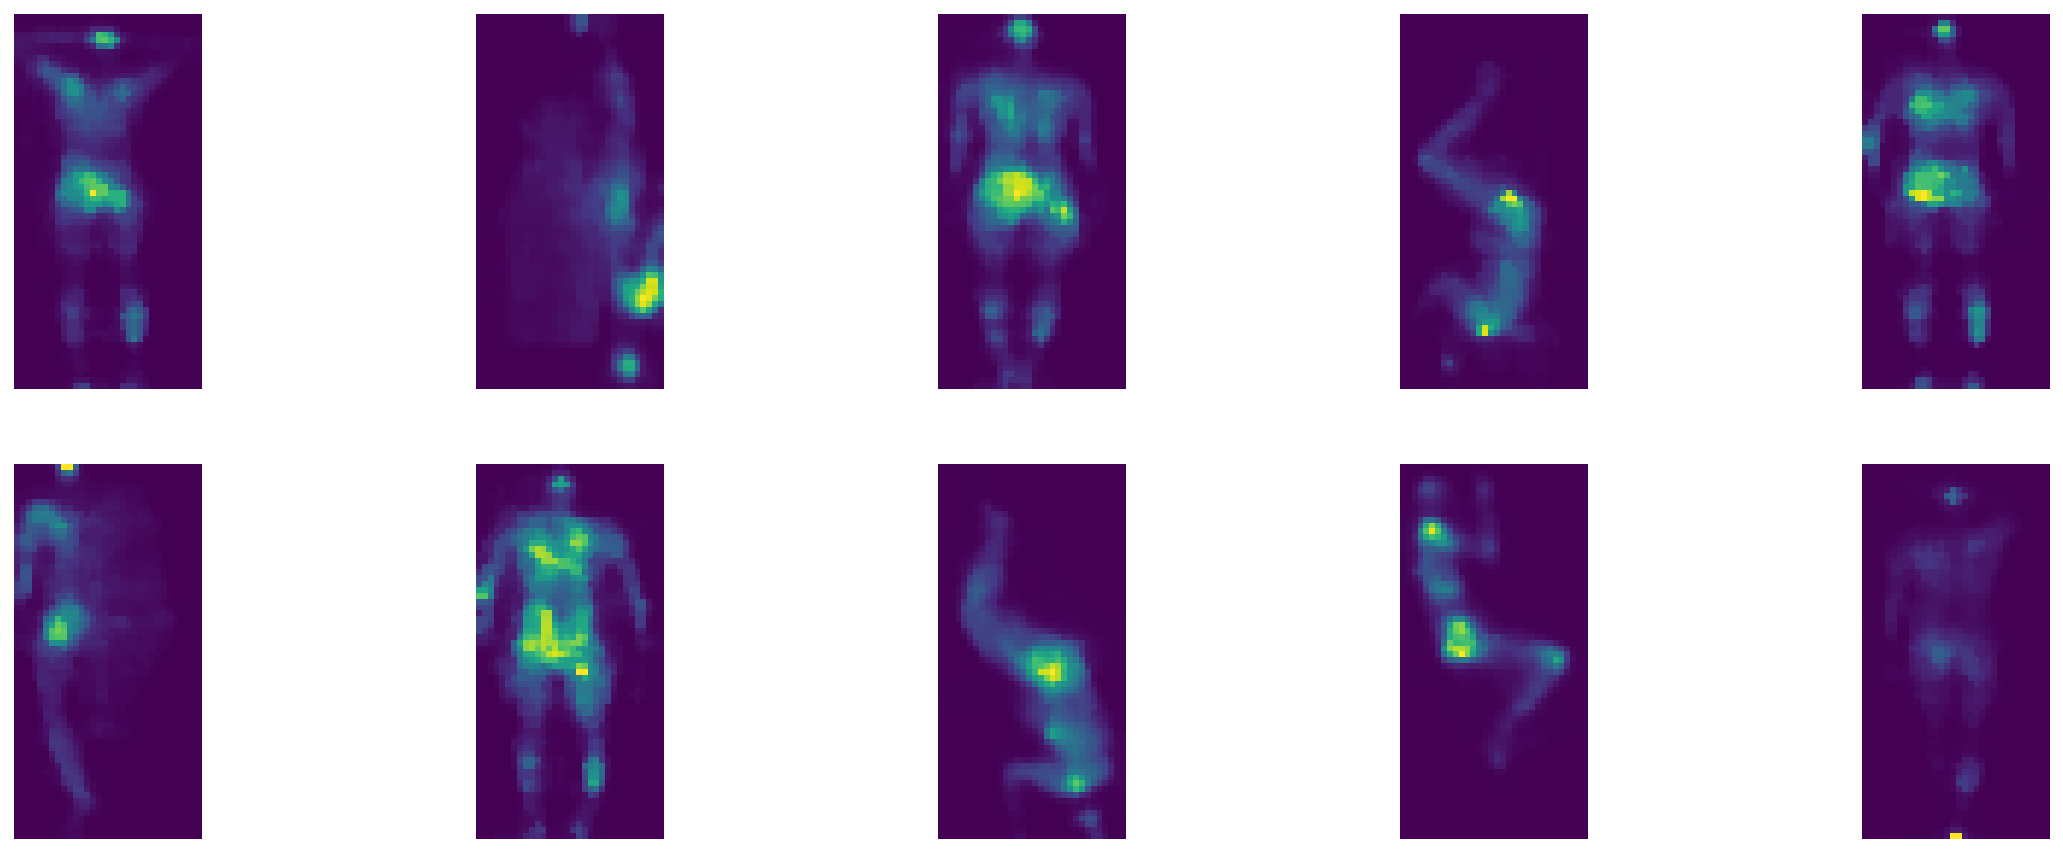

In [7]:
X_train, X_test, y_train_pos, y_train_sub, y_test_pos, y_test_sub = preprocess(frames, test_size=0.2)
X_train_aug = data_augmentation(X_train, plot=True)

In [18]:
from PIL import Image

for i in range(20):
    n = np.random.randint(0,100)
    img = Image.fromarray(X_test[n*i].reshape(64,32)*1000).convert("L")
    img.save('(pos{}-sub{}).png'.format(int(y_test_pos[n*i].argmax(-1))+1,int(y_test_sub[n*i].argmax(-1))+1))


In [17]:
np.unique(y_test_pos.argmax(-1))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=int64)

In [96]:
model, pos_layer, sub_layer = cnn_rnn_model(n_conv=2, n_channels=16, n_dense=3, n_neurons=128, n_pos=17, summary=True)

Model: "HDA"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 64, 32, 1)]  0           []                               
                                                                                                  
 layer_12 (Layer)               (None, 64, 32, 1)    0           ['Input[0][0]']                  
                                                                                                  
 Conv-1a (Conv2D)               (None, 62, 30, 16)   160         ['layer_12[0][0]']               
                                                                                                  
 batch_normalization_24 (BatchN  (None, 62, 30, 16)  64          ['Conv-1a[0][0]']                
 ormalization)                                                                                  

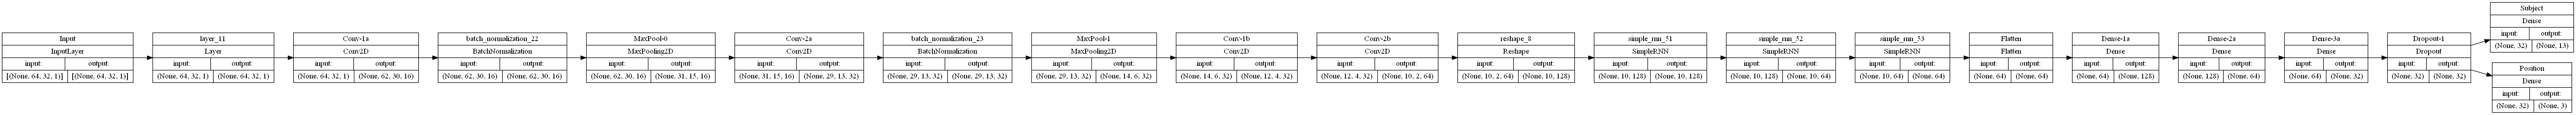

In [94]:
plot_model(model, show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='LR', expand_nested=True ) #per plot verticale cambiare 'LR' --> 'TB'

Epoch 1/30
120/120 [==============================] - 20s 137ms/step - loss: 2.1898 - Subject_loss: 2.1845 - Position_loss: 2.1951 - Subject_accuracy: 0.2601 - Position_accuracy: 0.2713 - val_loss: 2.7067 - val_Subject_loss: 2.5611 - val_Position_loss: 2.8522 - val_Subject_accuracy: 0.0973 - val_Position_accuracy: 0.0625 - lr: 0.0010
Epoch 2/30
120/120 [==============================] - 16s 132ms/step - loss: 1.3926 - Subject_loss: 1.4924 - Position_loss: 1.2928 - Subject_accuracy: 0.5033 - Position_accuracy: 0.5589 - val_loss: 2.7675 - val_Subject_loss: 2.5592 - val_Position_loss: 2.9757 - val_Subject_accuracy: 0.1154 - val_Position_accuracy: 0.0649 - lr: 0.0010
Epoch 3/30
120/120 [==============================] - 15s 127ms/step - loss: 0.9788 - Subject_loss: 1.0361 - Position_loss: 0.9215 - Subject_accuracy: 0.6535 - Position_accuracy: 0.6874 - val_loss: 2.8581 - val_Subject_loss: 2.5243 - val_Position_loss: 3.1920 - val_Subject_accuracy: 0.1525 - val_Position_accuracy: 0.0739 - lr:

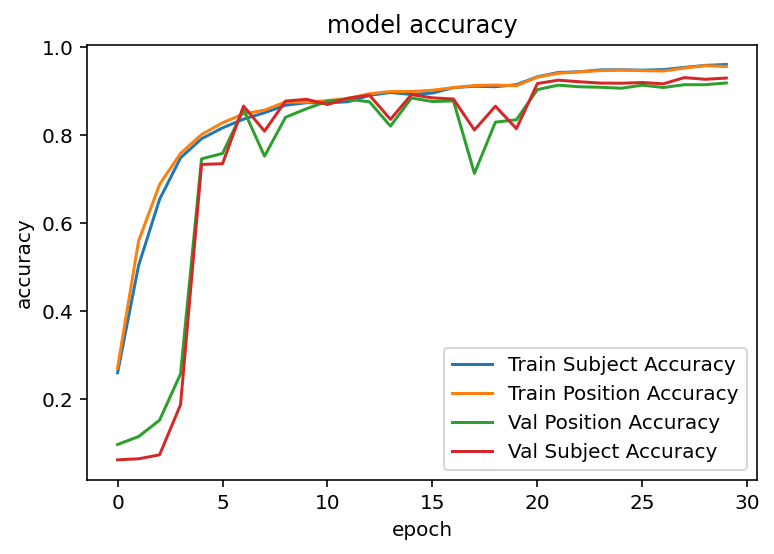

In [97]:
model = train_model(
                    model, X_train_aug, y_train_sub, y_train_pos,
                    n_epochs=30, lambda_=0.5, verbose=1, validation_split=0.2, batch_size=100,
                    plot=True, name_model='17_positions.h5')

Position Test accuracy: 99.87 %
Subject Test accuracy: 99.95 %
---------------------
---------------------
Posture Classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       216
           1       1.00      1.00      1.00       211
           2       1.00      1.00      1.00       217
           3       1.00      1.00      1.00       227
           4       1.00      1.00      1.00       228
           5       1.00      1.00      1.00       222
           6       1.00      1.00      1.00       246
           7       1.00      1.00      1.00       227
           8       0.99      1.00      1.00       215
           9       1.00      1.00      1.00       247
          10       1.00      1.00      1.00       228
          11       1.00      1.00      1.00       203
          12       1.00      1.00      1.00       200
          13       1.00      1.00      1.00       213
          14       1.00      1.00      1.00       22

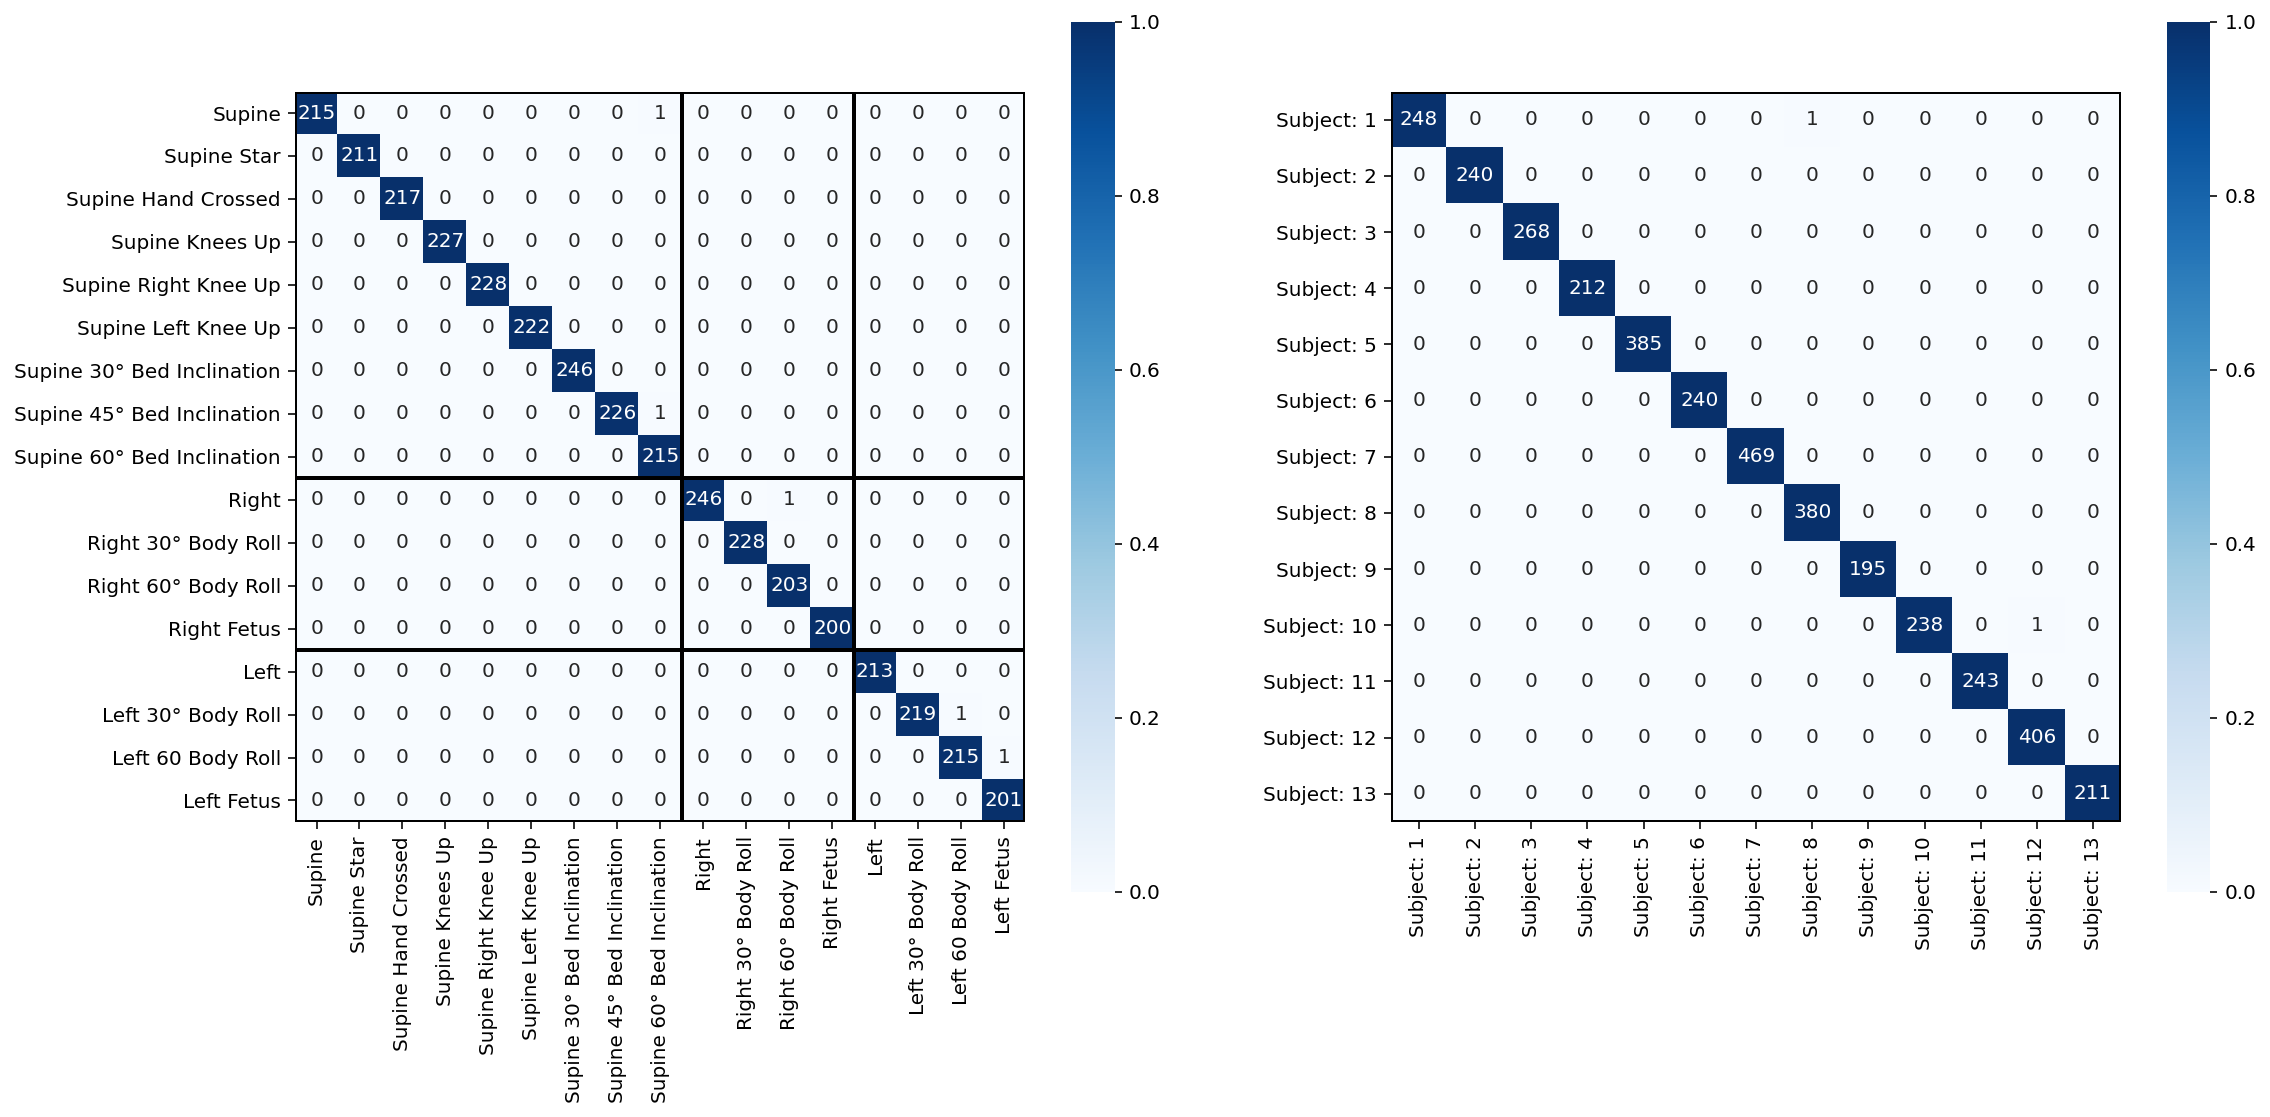

In [98]:
acc_pos, acc_pos, matrix_pos, matrix_sub = test_model(
                                                      X_test,y_test_sub, y_test_pos,
                                                      classification_rep=True, plot=True)

### K-Fold for Subject + 17 Positions

In [31]:
x = frames.iloc[:,:-2].values.reshape(len(frames),32,64,1)
x = np.concatenate((x[:,:,:32],x[:,:,32:])) 
x = ndimage.median_filter(x, 2) #applying median filter of size 2
x_aug = data_augmentation(x, plot=False)

y_pos = frames.iloc[:,-2].values
y_pos = pd.get_dummies(frames['posture']).values

y_sub = frames.iloc[:,-1].values
y_sub = pd.get_dummies(frames['subject']).values

y_pos = np.concatenate((y_pos,y_pos)) #double the dataset
y_sub = np.concatenate((y_sub,y_sub))

100%|███████████████████████████████████████████████████████████████████████████| 37396/37396 [03:04<00:00, 202.82it/s]

Data Augmentation Done!


In [32]:
##### MAKE SURE ALL THE CODE ABOVE IS ALREADY RUNNED
kfold_acc_pos = []
kfold_acc_sub = []
fold=5 #number of folds
k=1

matrix_pos_ = np.zeros((17,17))
matrix_sub_ = np.zeros((13,13))

print('-----------------')
print('KFold Initialization.')
print('-----------------')

cv = KFold(n_splits=fold, shuffle=True, random_state=123)
for train, test in cv.split(x):

    X_train, X_test = tf.gather(x_aug, indices=train), tf.gather(x, indices=test) #ATTENZIONE 
    y_train_pos, y_test_pos = y_pos[train], y_pos[test]
    y_train_sub, y_test_sub = y_sub[train], y_sub[test]
    
    if k==1: 
        summary=True
    else: summary=False
        
    model, pos_layer, sub_layer = build_model(n_neurons=80, n_pos=17, summary=summary)

    model = train_model(model, X_train, y_train_sub, y_train_pos, 
                        plot=False, n_epochs=3, verbose=0, lambda_=0.5)

    acc_pos, acc_sub, matrix_pos, matrix_sub = test_model(X_test,y_test_sub, y_test_pos, 
                                                          plot=False, classification_rep=False)

    matrix_sub_ += matrix_sub
    matrix_pos_ += matrix_pos

    kfold_acc_pos.append(acc_pos)
    kfold_acc_sub.append(acc_sub)
    
    print('-----------------')
    print('{}-Kfold finished!'.format(k))
    print('-----------------')
    
    tf.keras.backend.clear_session()
    k+=1

print('-----------------')
print('-----------------')
print('Average KFold Position Accuracy:',round(np.mean(kfold_acc_pos),2),'%')
print('Average Kfold Subject Accuracy:',round(np.mean(kfold_acc_sub),2),'%')


-----------------
KFold Initialization.
-----------------
Model: "HDA"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 Normalization (Normalization)  (None, 32, 32, 1)    3           ['Input[0][0]']                  
                                                                                                  
 Conv-0a (Conv2D)               (None, 30, 30, 8)    80          ['Normalization[0][0]']          
                                                                                                  
 Conv-0b (Conv2D)               (None, 28, 28, 16)   1168        ['Conv-0a[0][0]']                
                                      

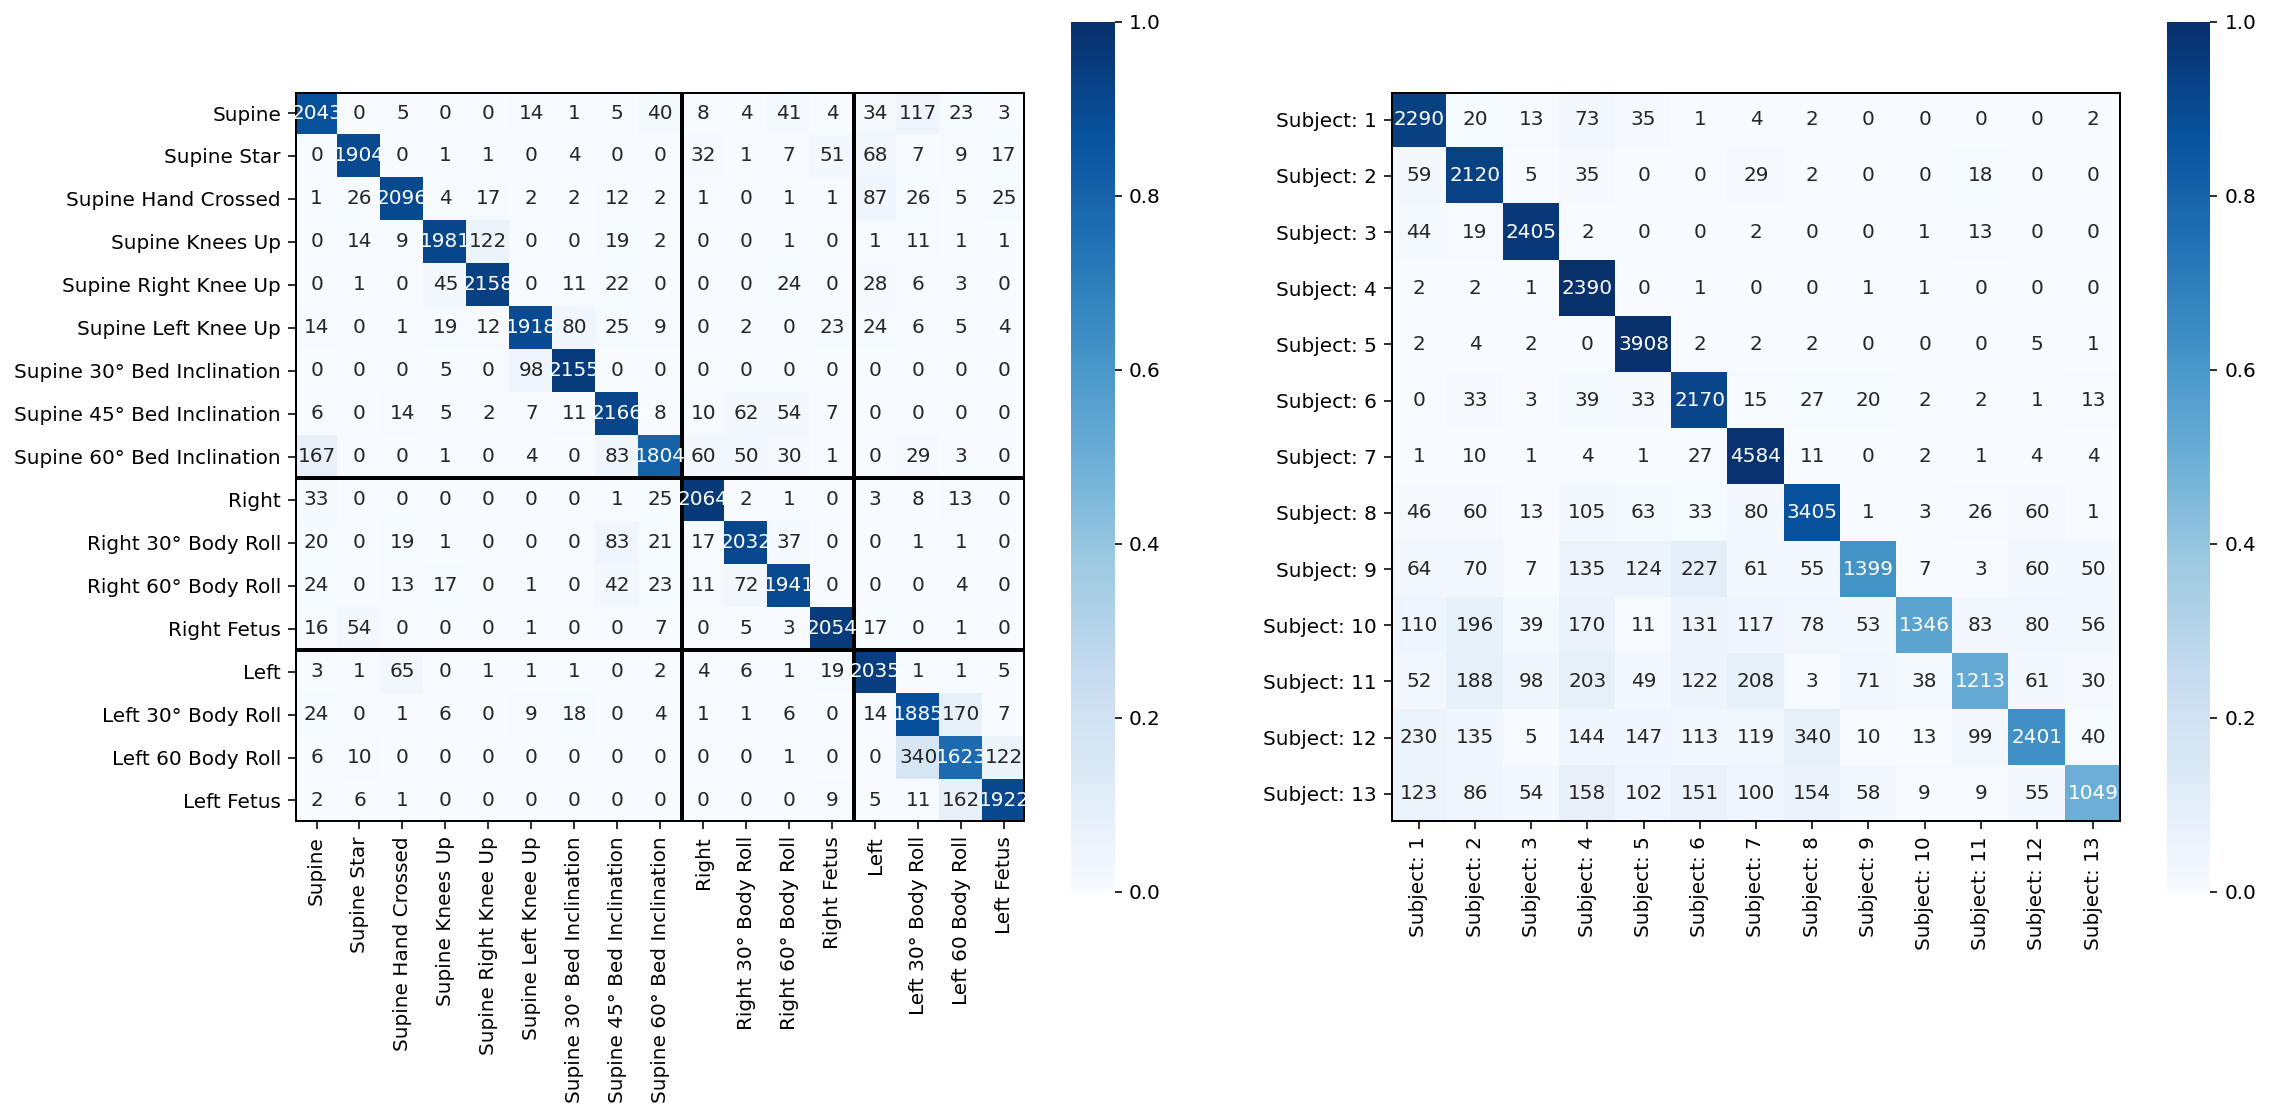

In [35]:
df = pd.DataFrame(matrix_pos_)
df.columns = [1,8,9,10,11,12,15,16,17,2,4,5,13,3,6,7,14]
df = df.rename(columns={1:'Supine',8:'Supine Star',9:'Supine Hand Crossed',10:'Supine Knees Up',
                   11:'Supine Right Knee Up',12:'Supine Left Knee Up',15:'Supine 30° Bed Inclination',16:'Supine 45° Bed Inclination',
                   17:'Supine 60° Bed Inclination',2:'Right',4:'Right 30° Body Roll',5:'Right 60° Body Roll',13:'Right Fetus',
                  3:'Left',6:'Left 30° Body Roll',7:'Left 60 Body Roll',14:'Left Fetus'})

#normalization
row_sums = matrix_sub_.sum(axis=1)
matrix_sub_norm = matrix_sub_ / row_sums[:, np.newaxis]
row_sums = matrix_pos_.sum(axis=1)
matrix_pos_norm = matrix_pos_ / row_sums[:, np.newaxis]

label_sub = [str('Subject: ')+str(i) for i in range(1,14)]

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(18,8)) 

sns.heatmap(matrix_pos_norm, annot=matrix_pos_,xticklabels=list(df.columns), yticklabels=list(df.columns),
            fmt="g",cmap='Blues',ax=ax1,vmin=0, vmax=1,square=True)
ax1.hlines([9, 13],*ax1.get_xlim(), color='black',lw=2)
ax1.vlines([9, 13],*ax1.get_xlim(), color='black',lw=2)
ax1.hlines([0],*ax1.get_xlim(), color='black',lw=2)
ax1.vlines([17],*ax1.get_xlim(), color='black',lw=2)
ax1.hlines([17],*ax1.get_xlim(), color='black',lw=2)
ax1.vlines([0],*ax1.get_xlim(), color='black',lw=2)

sns.heatmap(matrix_sub_norm, annot=matrix_sub_,xticklabels=label_sub, yticklabels=label_sub,
            fmt="g",cmap='Blues',ax=ax2,vmin=0, vmax=1,square=True)
ax2.hlines([0],*plt.xlim(), color='black',lw=2)
ax2.vlines([13],*plt.xlim(), color='black',lw=2)
ax2.hlines([13],*plt.xlim(), color='black',lw=2)
ax2.vlines([0],*plt.xlim(), color='black',lw=2)

plt.show()

## Accuracy Riferimento

In [4]:
frames = pd.read_csv('Experiment1_17pos.csv',  header=0)
frames = frames.drop(range(7939, 7951))
frames = frames.drop([6767, 10147])
frames.head(5)

,0,1,2,3,4,5,6,7,8,9,...,2040,2041,2042,2043,2044,2045,2046,2047,posture,subject
0,0,0,0,0,1,0,5,4,5,2,...,0,0,0,0,0,0,0,0,1,1
1,0,1,0,0,1,0,6,4,5,1,...,0,0,0,0,0,0,0,0,1,1
2,0,0,0,0,1,0,5,4,4,1,...,0,0,0,0,0,0,0,0,1,1
3,0,0,0,0,1,0,5,4,4,1,...,0,0,0,0,0,0,0,0,1,1
4,0,0,0,0,0,0,6,4,4,1,...,0,0,0,0,0,0,0,0,1,1


  0%|                                                                                        | 0/14947 [00:00<?, ?it/s]

X train (14947, 64, 32, 1)
X test (3737, 64, 32, 1)
Y train position (14947, 17)
Y train subject (14947, 13)
Y test position (3737, 17)
Y test subject (3737, 13)


100%|██████████████████████████████████████████████████████████████████████████| 14947/14947 [00:12<00:00, 1164.90it/s]


Data Augmentation Done!


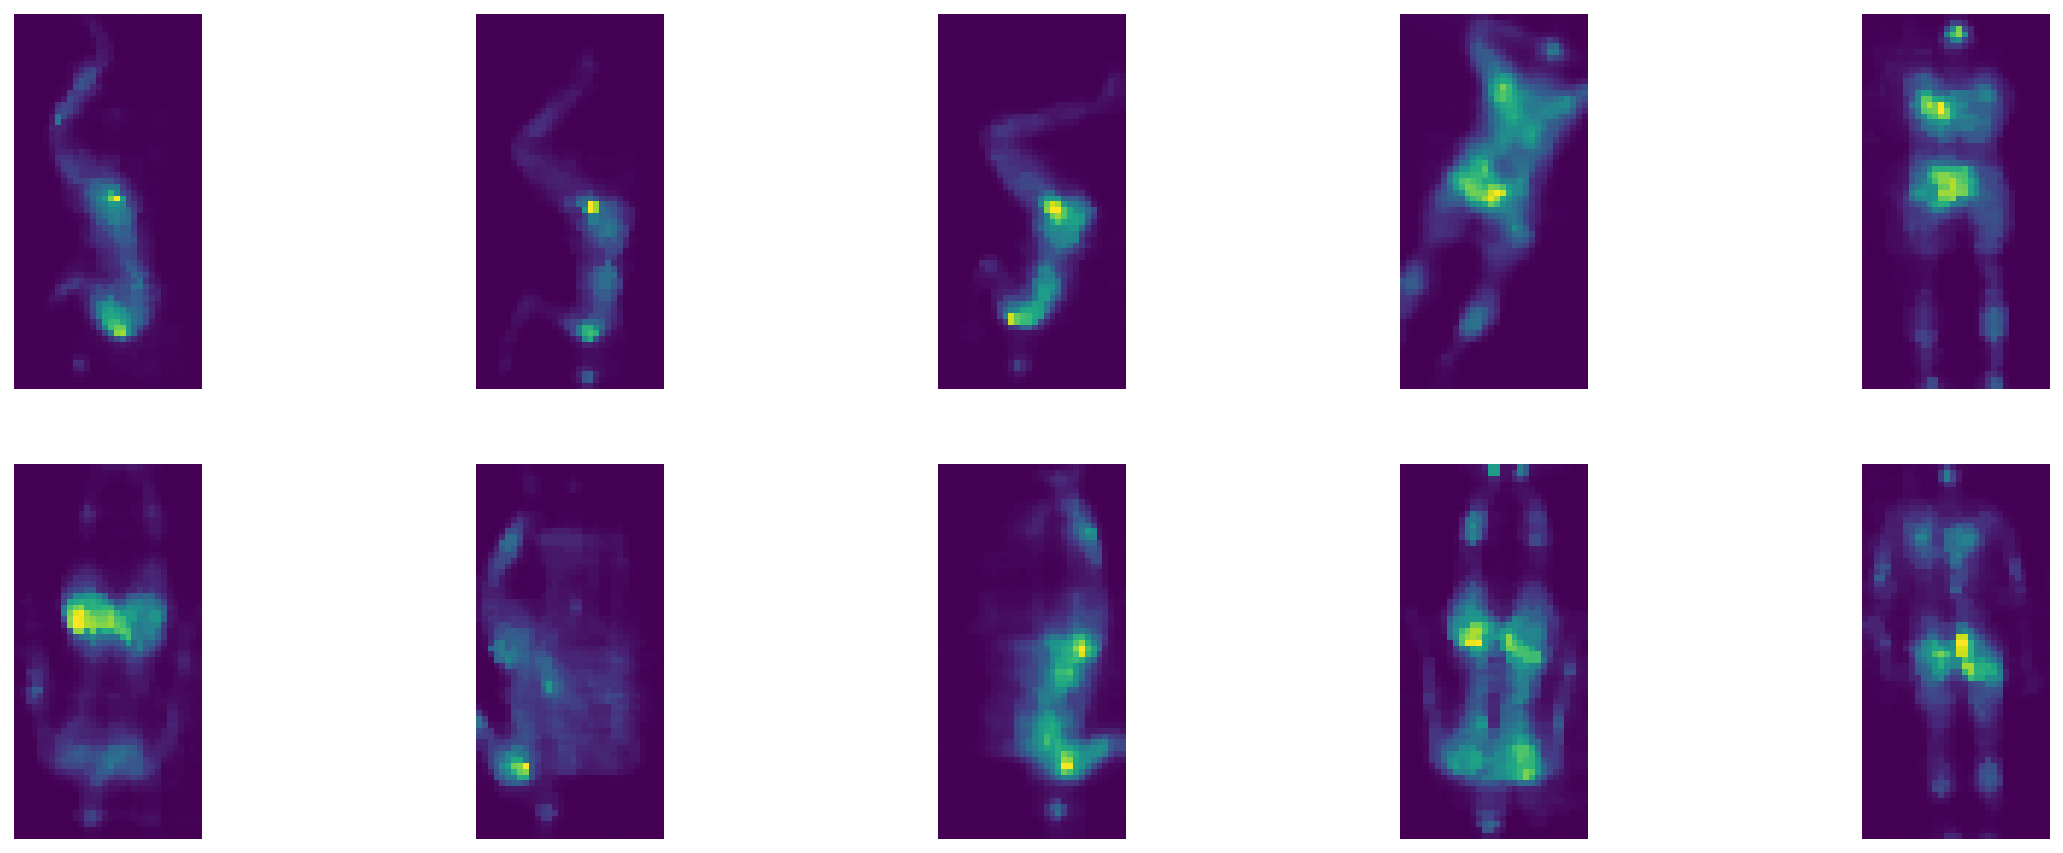

In [28]:
X_train, X_test, y_train_pos, y_train_sub, y_test_pos, y_test_sub = preprocess(frames, test_size=0.2)
X_train_aug = data_augmentation(X_train, plot=True)

In [29]:
X_train_aug = X_train_aug.reshape(len(X_train_aug),64*32)
X_test = X_test.reshape(len(X_test),64*32)

y_train_pos = y_train_pos.argmax(-1)
y_test_pos = y_test_pos.argmax(-1)

### Gradient Boosting

In [6]:
from sklearn.ensemble import GradientBoostingClassifier

In [24]:
gb = GradientBoostingClassifier(verbose=2).fit(X_train_aug, y_train_pos)

      Iter       Train Loss   Remaining Time 


KeyboardInterrupt: 

In [ ]:
print('Accuracy',gb.score(X_test, y_test_pos))

### Random Forest

In [6]:
from sklearn.ensemble import RandomForestClassifier

In [9]:
rf = RandomForestClassifier(max_depth=8, random_state=0, verbose=1, n_jobs=-1).fit(X_train_aug, y_train_pos)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.8s finished


In [10]:
print('Accuracy',rf.score(X_test, y_test_pos))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy 0.9970564624029971


### KNN

In [11]:
from sklearn.neighbors import KNeighborsClassifier

In [12]:
neigh = KNeighborsClassifier(n_neighbors=3).fit(X_train_aug, y_train_pos)

In [13]:
print('Accuracy',neigh.score(X_test, y_test_pos))

Accuracy 0.9997324056729997


### Adaboost

In [31]:
from sklearn.ensemble import AdaBoostClassifier

In [34]:
ada = AdaBoostClassifier(n_estimators=100, random_state=0).fit(X_train_aug, y_train_pos)

KeyboardInterrupt: 

In [ ]:
print('Accuracy',ada.score(X_test, y_test_pos))

### SVC

In [30]:
from sklearn.svm import SVC

In [ ]:
svc = SVC(kernel='poly',gamma='auto', verbose=True).fit(X_train_aug, y_train_pos)

[LibSVM]

In [ ]:
print('Accuracy',svc.score(X_test, y_test_pos))

# K-Fold

In [14]:
x = frames.iloc[:,:-2].values.reshape(len(frames),64,32,1)
x = ndimage.median_filter(x, 3) 
norm = lambda s: s/1000            #1000 is the maximum value of the pressure on the sensors
x = np.array([norm(xx) for xx in x])

x_aug = data_augmentation(x, plot=False)

x = x.reshape(len(x),64*32)
x_aug = x_aug.reshape(len(x_aug),64*32)

y_pos = frames.iloc[:,-2].values

100%|███████████████████████████████████████████████████████████████████████████| 18684/18684 [00:18<00:00, 991.38it/s]

Data Augmentation Done!


In [24]:
##### MAKE SURE ALL THE CODE ABOVE IS ALREADY RUNNED
kfold_acc_pos = []

fold=10 #number of folds
k=1

matrix_pos_ = np.zeros((17,17))

print('-----------------')
print('KFold Initialization.')
print('-----------------')

cv = KFold(n_splits=fold, shuffle=True, random_state=123)

for train, test in cv.split(x):

    X_train, X_test = x_aug[train], x[test] #ATTENZIONE 
    y_train_pos, y_test_pos = y_pos[train], y_pos[test]

    neigh = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train_pos)
    
    y_pred = neigh.predict(X_test)
    y_true = y_test_pos
    
    
    acc_pos = neigh.score(X_test, y_test_pos)*100

    matrix_pos = confusion_matrix(y_true, y_pred)
    matrix_pos_ += matrix_pos

    kfold_acc_pos.append(acc_pos)
    
    print('-----------------')
    print('{}-Kfold finished!'.format(k))
    print('-----------------')
    k+=1

print('-----------------')
print('-----------------')
print('Average KFold Position Accuracy:',round(np.mean(kfold_acc_pos),2),'%')


-----------------
KFold Initialization.
-----------------
-----------------
1-Kfold finished!
-----------------
-----------------
2-Kfold finished!
-----------------
-----------------
3-Kfold finished!
-----------------
-----------------
4-Kfold finished!
-----------------
-----------------
5-Kfold finished!
-----------------
-----------------
6-Kfold finished!
-----------------
-----------------
7-Kfold finished!
-----------------
-----------------
8-Kfold finished!
-----------------
-----------------
9-Kfold finished!
-----------------
-----------------
10-Kfold finished!
-----------------
-----------------
-----------------
Average KFold Position Accuracy: 99.94 %
